In [78]:
import os

import keras
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle
from tqdm import tqdm
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense

In [88]:
def convert_list_of_arrays_to_padded_array(list_varying_sizes, pad_value=0):
    max_shape = [0] * len(list_varying_sizes[0].shape)

    for arr in list_varying_sizes:
        shape = arr.shape
        max_shape = [max(s1, s2) for s1, s2 in zip(shape, max_shape)]
    padded_array = pad_value * np.ones((len(list_varying_sizes), *max_shape))

    for a, arr in enumerate(list_varying_sizes):
        r, c = arr.shape
        padded_array[a, :r, :c] = arr

    return padded_array


def preprocess_encoder_input(arr):
    '''
    Simple method to handle the complex MFCC coefs that are produced during preprocessing. This means:
    1. (For now), discarding one of the channels of the MFCC coefs
    2. Collapsing any empty dimensions
    '''
    return arr.squeeze()


with open('../data/one-hot.pkl', 'rb') as one_hot_quran_pickle_file:
    one_hot_obj = pickle.load(one_hot_quran_pickle_file)


def get_one_hot_encoded_verse(surah_num, ayah_num):
    one_hot_verse = one_hot_obj['quran']['surahs'][surah_num - 1]['ayahs'][ayah_num - 1]['text']
    num_chars_in_verse, num_unique_chars = one_hot_verse.shape

    decoder_input = np.zeros((num_chars_in_verse + 2, num_unique_chars + 2)) # +2 for START and END tokens
    decoder_input[0, :] = [0] * num_unique_chars + [1, 0] # START token
    decoder_input[1:num_chars_in_verse + 1, :-2] = one_hot_verse # Original verse
    decoder_input[-1, :] = [0] * num_unique_chars + [0, 1] # END token

    decoder_target = np.zeros((num_chars_in_verse + 2, num_unique_chars + 2)) # +2 for START and END tokens
    decoder_target[:num_chars_in_verse, :-2] = one_hot_verse # Original verse
    decoder_target[-2, :] = [0] * num_unique_chars + [0, 1] # END token

    return decoder_input, decoder_target


def build_dataset(local_coefs_dir='../data/mfcc', surahs=None, n=100):
    if surahs is None:
        surahs = [1]

    def get_encoder_and_decoder_data(n=100):
        count = 0
        encoder_input_data = []
        decoder_input_data = []
        decoder_target_data = []
        for surah_num in surahs:
            local_surah_dir = os.path.join(local_coefs_dir, "surah_" + str(surah_num))
            for _, ayah_directories, _ in os.walk(local_surah_dir):
                for ayah_directory in ayah_directories:
                    ayah_num = ayah_directory[5:]
                    local_ayah_dir = os.path.join(local_surah_dir, ayah_directory)
                    for _, _, recording_filenames in os.walk(local_ayah_dir):
                        for recording_filename in recording_filenames:
                            local_coefs_path = os.path.join(local_ayah_dir, recording_filename)
                            encoder_input = np.load(local_coefs_path)
                            encoder_input = preprocess_encoder_input(encoder_input)
                            encoder_input_data.append(encoder_input)

                            decoder_input, decoder_target = get_one_hot_encoded_verse(int(surah_num), int(ayah_num))
                            decoder_input_data.append(decoder_input)
                            decoder_target_data.append(decoder_target)
                            count += 1
                            if count == n:
                                return encoder_input_data, decoder_input_data, decoder_target_data
        return encoder_input_data, decoder_input_data, decoder_target_data

    encoder_input_data, decoder_input_data, decoder_target_data = get_encoder_and_decoder_data(n=n)
    encoder_input_data = convert_list_of_arrays_to_padded_array(encoder_input_data)
    decoder_input_data = convert_list_of_arrays_to_padded_array(decoder_input_data)
    decoder_target_data = convert_list_of_arrays_to_padded_array(decoder_target_data)
    return encoder_input_data, decoder_input_data, decoder_target_data

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [87]:
batch_size = 10
epochs = 25
latent_dim = 10
n = 100

encoder_input_data, decoder_input_data, decoder_target_data = build_dataset(n=n)

38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
38 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
37 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
23 59
40 59
40 59
40 59
40 59
40 59
40 59
40 59
40 59
40 59
40 59
40 59
40 59
90 59
90 59
90 59
90 59
90 59
90 59
90 59
90 59
90 59
90 59
90 59
90 59
34 59
34 59
34 59
34 59
34 59
34 59
34 59
34 59
34 59
34 59
34 59
34 59


In [59]:
[print(a.shape) for a in [encoder_input_data, decoder_input_data, decoder_target_data]]

max_encoder_seq_length = encoder_input_data.shape[1]
max_decoder_seq_length = decoder_input_data.shape[1]
num_encoder_tokens = encoder_input_data.shape[-1]
num_decoder_tokens = decoder_input_data.shape[-1]

(89, 1860, 13)
(89, 92, 61)
(89, 92, 61)


In [79]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

2023-06-10 10:33:19.602506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 10:33:19.604139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 10:33:19.605661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [61]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/25


2023-06-10 09:34:42.600096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 09:34:42.602162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 09:34:42.604294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 1.7040

2023-06-10 09:34:48.083059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 09:34:48.084324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 09:34:48.085883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 6s 429ms/step - loss: 1.7040 - val_loss: 2.3823
Epoch 2/25
8/8 [==============================] - 3s 388ms/step - loss: 1.6947 - val_loss: 2.3706
Epoch 3/25
8/8 [==============================] - 3s 419ms/step - loss: 1.6848 - val_loss: 2.3564
Epoch 4/25
8/8 [==============================] - 3s 362ms/step - loss: 1.6719 - val_loss: 2.3363
Epoch 5/25
8/8 [==============================] - 3s 332ms/step - loss: 1.6542 - val_loss: 2.3083
Epoch 6/25
8/8 [==============================] - 3s 374ms/step - loss: 1.6325 - val_loss: 2.2798
Epoch 7/25
8/8 [==============================] - 3s 344ms/step - loss: 1.6118 - val_loss: 2.2521
Epoch 8/25
8/8 [==============================] - 3s 337ms/step - loss: 1.5917 - val_loss: 2.2210
Epoch 9/25
8/8 [==============================] - 3s 347ms/step - loss: 1.5701 - val_loss: 2.1985
Epoch 10/25
8/8 [==============================] - 3s 405ms/step - loss: 1.5531 - val_loss: 2.1728
Epoch 11/25
8/8 [=============

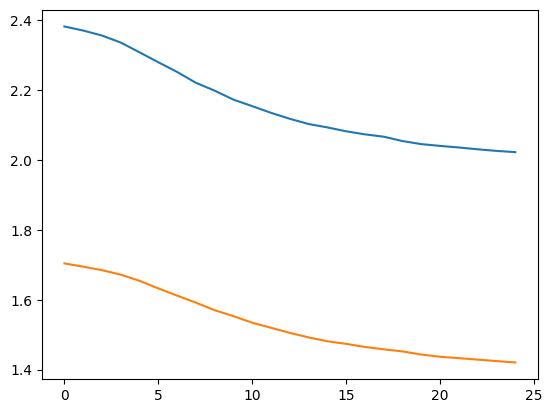

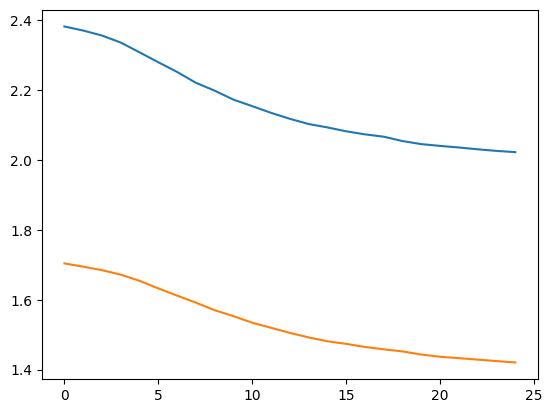

In [63]:
plt.plot(range(epochs), history.history['val_loss'])
plt.plot(range(epochs), history.history['loss'])

In [64]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

2023-06-10 09:36:23.564203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 09:36:23.565828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 09:36:23.566943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [65]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_target_char_index = one_hot_obj['int_to_char']
reverse_target_char_index[num_decoder_tokens - 2] = '->'
reverse_target_char_index[num_decoder_tokens - 1] = '<-'

target_char_index = {v: k for k, v in reverse_target_char_index.items()}

In [69]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_char_index['->']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<-' or
                len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('Predicted verse:', decoded_sentence)

Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
Predicted verse: َََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََََ
P